**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

# !pip install imbalanced-learn --user
#!pip install imblearn

In [61]:
import gc # сборщик мусора
import datetime # для работы со времнем
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, ShuffleSplit, learning_curve
from sklearn import svm
from sklearn.ensemble import VotingClassifier, StackingClassifier

import pickle
import random
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# клакстеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

0.7.0


In [3]:
#from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

In [105]:
DATASET_PATH = 'course_project_train.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [106]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F609D12E8>,
      dtype=object)

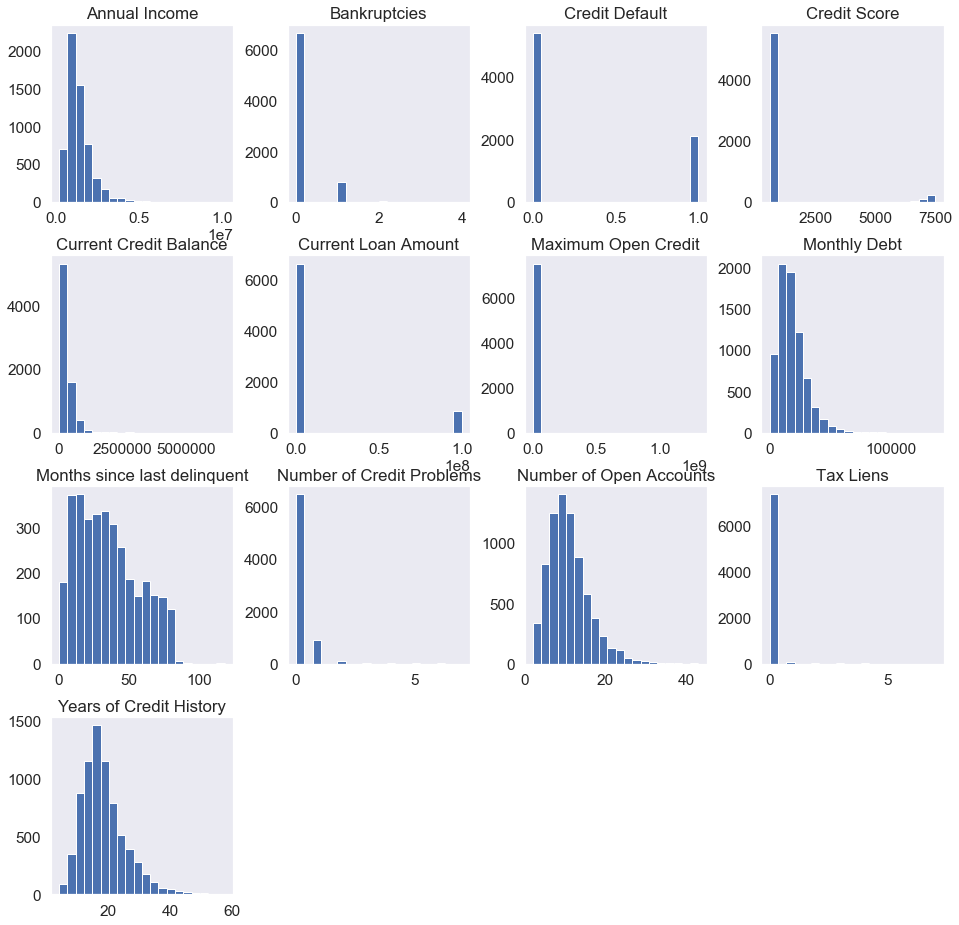

In [107]:
df.hist(figsize=(16,16), bins=20, grid=False)

In [108]:
TARGET_NAME = 'Credit Default'

In [109]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [110]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обработка выбросов пропусков

In [111]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mins = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()
        self.mins = df.min()

        
    def transform(self, df):
        """Трансформация данных"""

        # Исправляем выбросы по Credit Score - очевидно что там лишний ноль дописали 
        df.loc[(df['Credit Score']>850),'Credit Score'] = df['Credit Score']/10
        
        # Вместо Nan в "Months since last delinquent" ставим 0, так как логично допустить что когда нет просрочемк то и не вводили
        
        df.loc[(df['Months since last delinquent'].isnull()),'Months since last delinquent'] = 0
        
        # Аналогично по банкротствам
        df.loc[(df['Bankruptcies'].isnull()),'Bankruptcies'] = 0
        
        # Правим Credit Score и Annual Income у них Nan одновременно, что логично если не завели средний годовой доход то Credit Score не считается
        # Если количество месяцев просрочки меньше 1 и Years in current job не Null:
       
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Annual Income'] = df['Monthly Debt']*18
        
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Credit Score'] = self.medians['Credit Score']
        # Если количество месяцев просрочки больше 0 :
        df.loc[(df['Credit Score'].isnull()),['Annual Income','Credit Score']] = [0,self.mins['Credit Score']]
        
        # Правим Years in current job как меньшее из значений
        df.loc[(df['Years in current job'].isnull()),'Years in current job'] = '< 1 year'
        
        # Есть выбросы в Current Loan Amount ( = 99999999.0),но данная величина очень хорошо коррелирует с Credit Default = 0, 
        # так что оставим как есть
        # но оценив этот признак в разрезе целевой переменной получается что лучше переопределить этот показатель на 100 000
        # так с точки зрения распределения при увеличении Current Loan Amount идет увеличение Credit Default = 1
        df.loc[df['Current Loan Amount']> 1000000,'Current Loan Amount'] = 100000
        
        # КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
        # Объединим некоторые параметры в поле 'Years in current job'
        df.loc[df['Years in current job'].isin(['1 year','4 years','3 years']),'Years in current job'] = '2 years'
        df.loc[df['Years in current job'].isin(['6 years','7 years','8 years','9 years']),'Years in current job'] = '5 years'
        
        # Аналогично для Purpose
        df.loc[df['Purpose'].isin(['take a trip','buy a car','small business','business loan','wedding','educational expenses',\
                                   'buy house','medical bills','moving','major purchase','vacation', 'renewable energy']),'Purpose'] = 'other'
        
        # Объединим Home Mortgage' и 'Have Mortgage' в колонке 'Home Ownership'
        df.loc[df['Home Ownership'] == 'Have Mortgage','Home Ownership'] = 'Home Mortgage'
        return df


In [112]:
pipe = DataPipeline()
pipe.fit(df) # расчет статистик
df = pipe.transform(df)

In [113]:
df.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

-------------

In [114]:
DATASET_PATH = 'course_project_test.csv'
df1 = pd.read_csv(DATASET_PATH)
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [115]:
# расчет статистик для тестовой выборки
df1 = pipe.transform(df1)

In [116]:
df1.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

## Анализ признаков


### Матрица корреляций

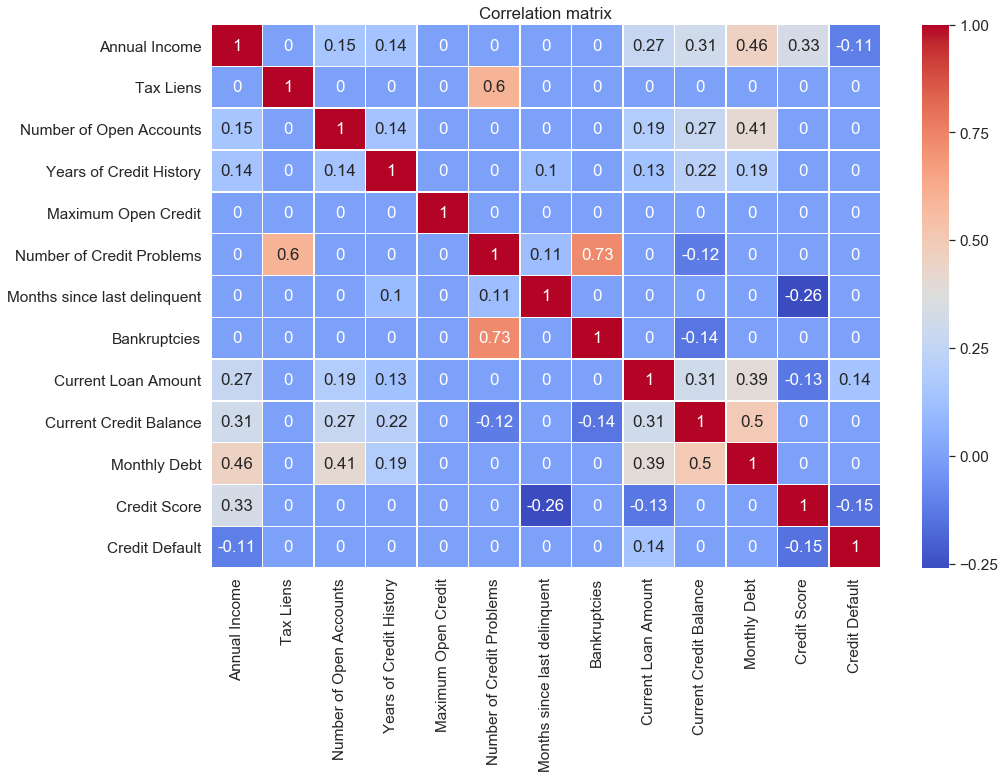

In [18]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [19]:
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

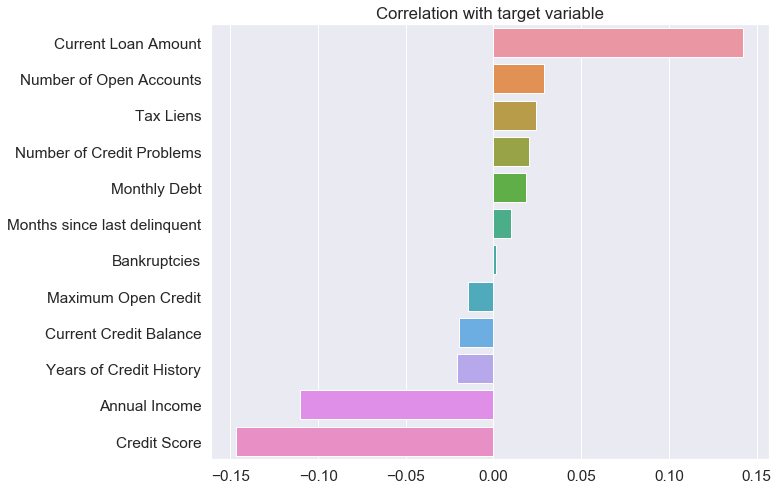

In [20]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [22]:
def countplot(df,vname,tname = TARGET_NAME):
    
    plt.figure(figsize=(10, 8))

    sns.countplot(x=vname, hue=TARGET_NAME, data=df)
    plt.title(f'{vname} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

In [117]:
df.select_dtypes(include='object')
CAT_FEATURES = df.select_dtypes(include='object').columns.tolist()
CAT_FEATURES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

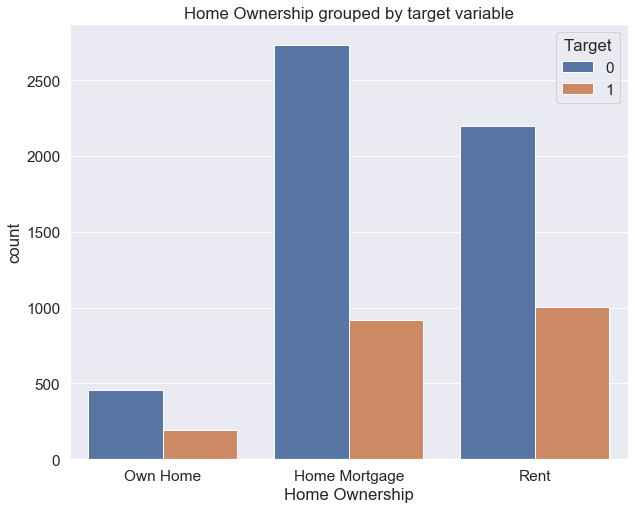

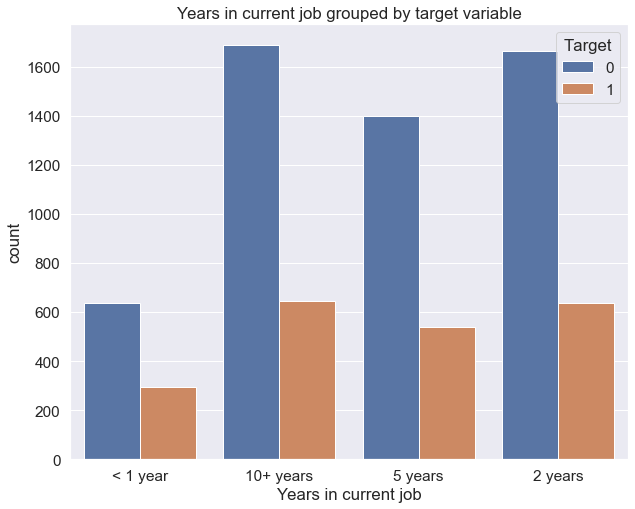

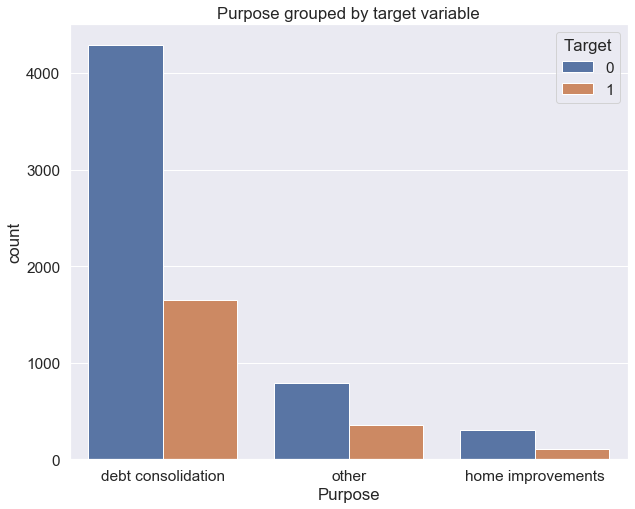

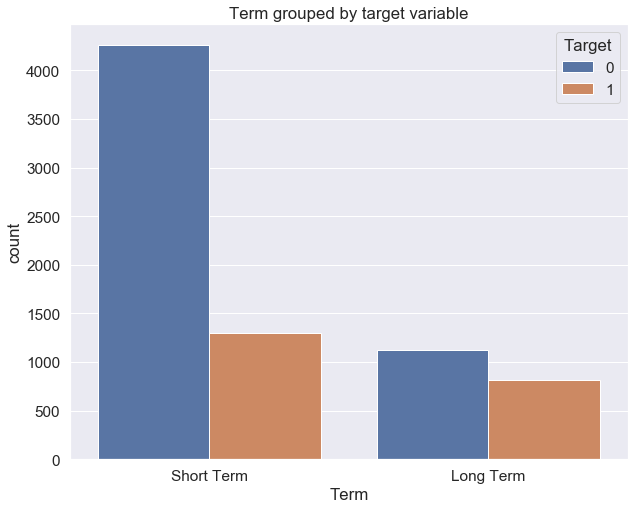

In [24]:
for vname in CAT_FEATURES:
    countplot(df,vname)

In [25]:
df1['Purpose'].value_counts()

debt consolidation    1973
other                  387
home improvements      140
Name: Purpose, dtype: int64

In [26]:
var_p = pd.unique(df['Purpose']).tolist()
print(f'name\t\t0\t\t1\t\trate')
for i in var_p:
    c0 = df.loc[(df['Purpose'] == i) & (df[TARGET_NAME] == 0),'Purpose'].count()
    c1 = df.loc[(df['Purpose'] == i) & (df[TARGET_NAME] == 1),'Purpose'].count()
    print(f'{c0+c1}\t\t{c0}\t\t{c1}\t\t{c1/(c0)}\t\t{i}')
var_p

name		0		1		rate
5944		4290		1654		0.38554778554778557		debt consolidation
1144		793		351		0.4426229508196721		other
412		304		108		0.35526315789473684		home improvements


['debt consolidation', 'other', 'home improvements']

Имеет смысл оставить только три группы: debt consolidation, other, home improvements

In [118]:
NUM_FEATURES = df.columns.drop(CAT_FEATURES +[TARGET_NAME]).tolist()
NUM_FEATURES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [28]:
def plot_by_target(df,vname,tname):
    X = df[[vname, tname]]
    X_0 = X.loc[X[tname]==0,vname]
    X_1 = X.loc[X[tname]==1,vname]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(X_0, shade=True, label='No default', color='g')
    sns.kdeplot(X_1, shade=True, label='Default', color='r')

    plt.xlabel(f'{vname}')
    plt.title(f'{vname} grouped by target variable')
    plt.show()


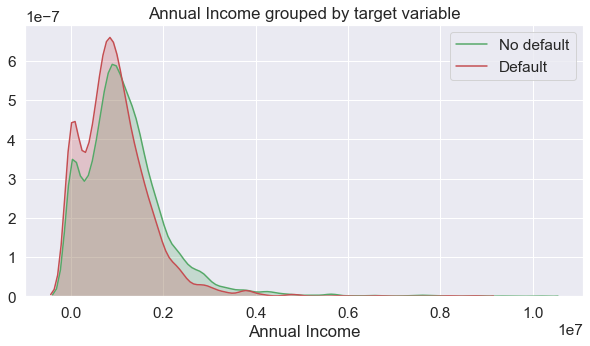

In [29]:
plot_by_target(df,'Annual Income',TARGET_NAME)

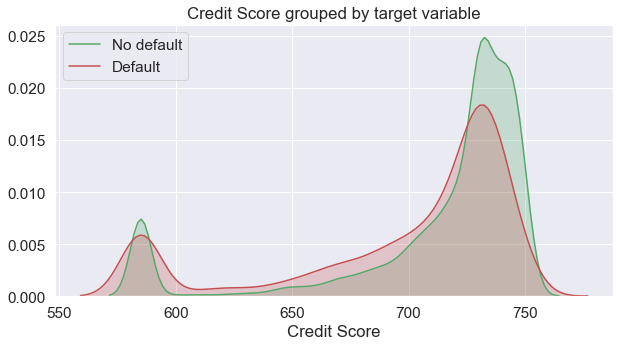

In [30]:
plot_by_target(df,'Credit Score',TARGET_NAME)

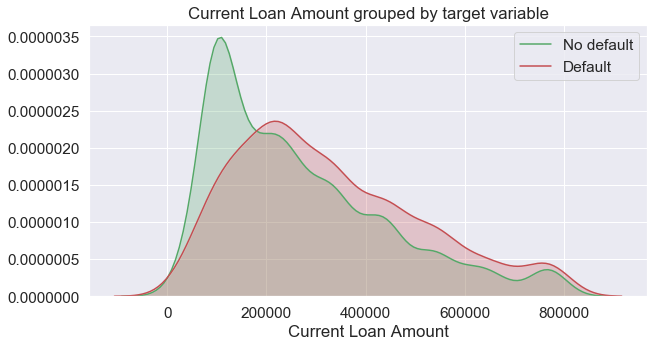

In [31]:
plot_by_target(df,'Current Loan Amount',TARGET_NAME)

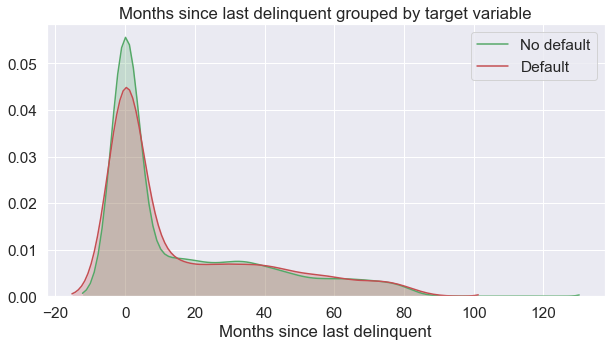

In [32]:
plot_by_target(df,'Months since last delinquent',TARGET_NAME)

In [33]:
df.loc[df['Months since last delinquent']==0,TARGET_NAME].value_counts()

0    2963
1    1136
Name: Credit Default, dtype: int64

In [34]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

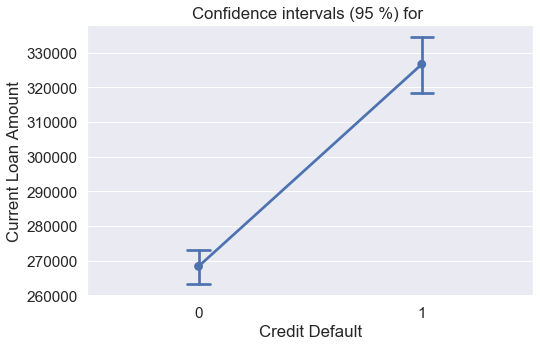

In [35]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=df[df['Current Loan Amount']<1000000], capsize=.1)

plt.title('Confidence intervals (95 %) for ')
plt.show()

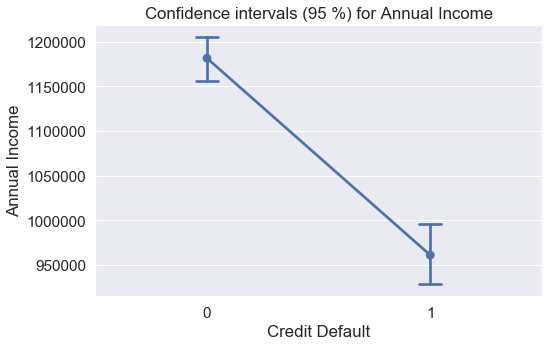

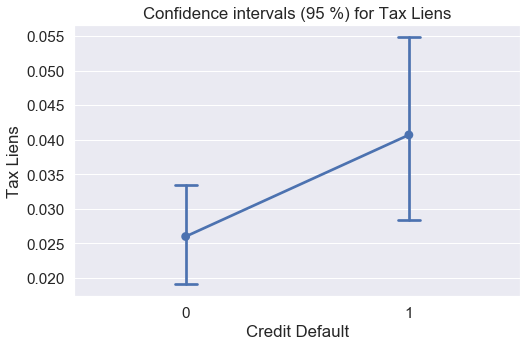

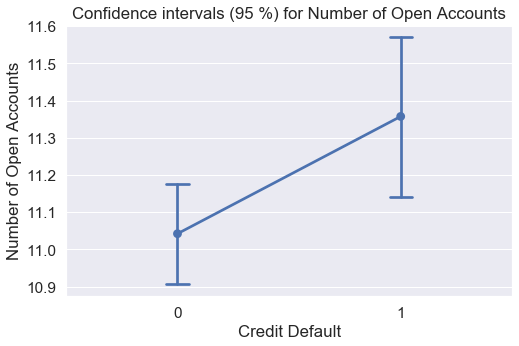

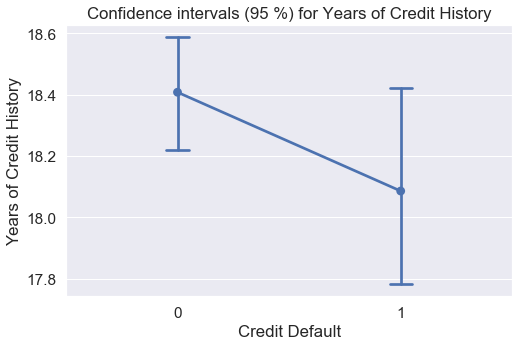

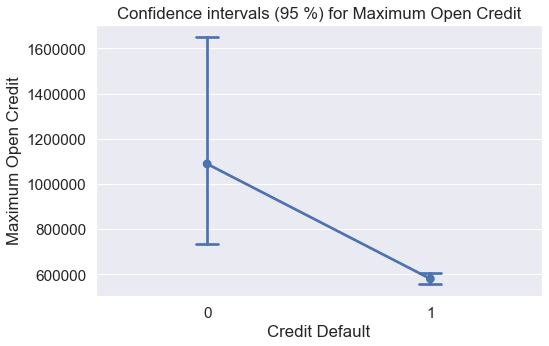

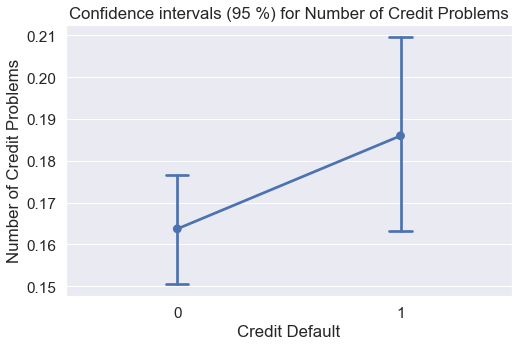

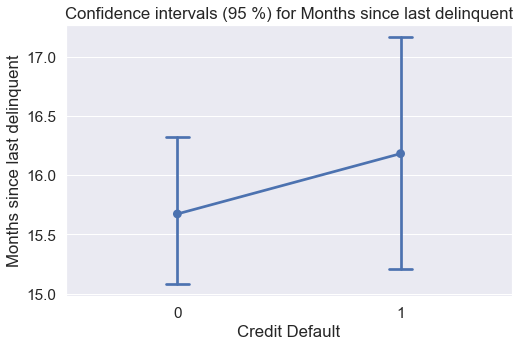

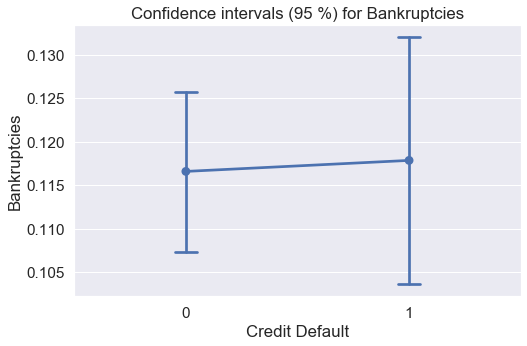

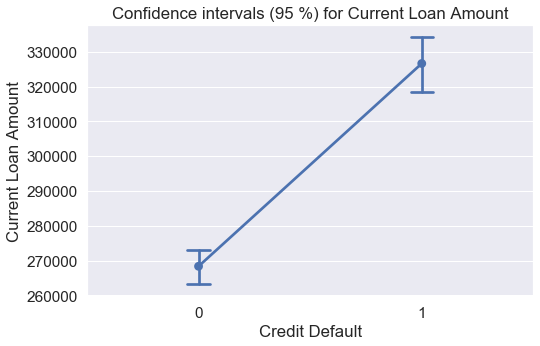

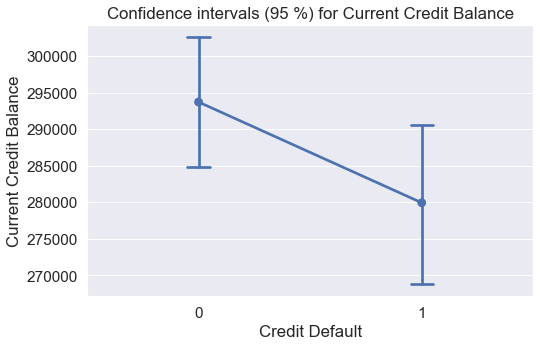

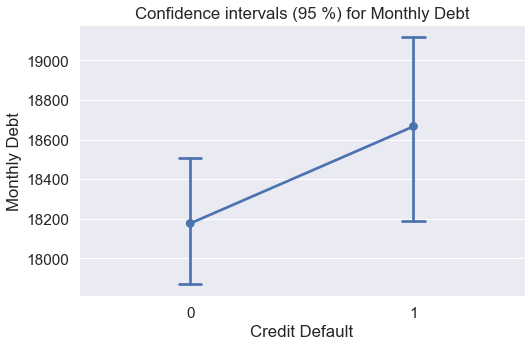

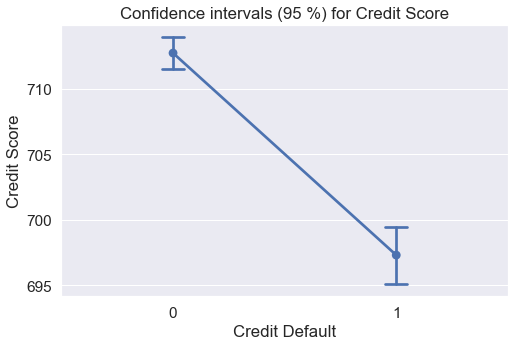

In [36]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=vname, data=df, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

Построив доверительные интервалы для средних значений, каждой из двух групп по целевой переменной и сравнимв их, получаем что: параметры: 'Annual Income','Maximum Open Credit', 'Maximum Open Credit','Current Loan Amount','Credit Score' имеют различные распределения (у них даже доверительные интервалы не пересекаются) и эти признаки может быть полезен для определения значения целевой переменной.
Остальные параметры хотя средние величины и отличаются но имеют пересекающиеся области доверительных интеравалов, что говорит о более слабом характере влияния этих параметров на целевую переменную.
А у параметра  'Bankruptcies'даже средняя величина мало отличается (что может быть еще связано с тем что очень большой перекос по количеству отличных от 0 значений)

-------
#### Проведем оценку распределений для тестового и тренировочного наборов

In [37]:
X_train = df.drop(TARGET_NAME,axis = 1)


In [38]:
X_train['db'] = 'train'

In [39]:
X_test = df1.copy()
X_test['db'] = 'test'
X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,db
0,Rent,0.0,2 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,585.0,test
1,Rent,231838.0,2 years,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,other,Short Term,78298.0,46037.0,2318.0,699.0,test
2,Home Mortgage,1152540.0,2 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,test
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,test
4,Home Mortgage,2340952.0,5 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,test


In [40]:
X = pd.concat([X_train,X_test])

In [41]:
X.shape

(10000, 17)

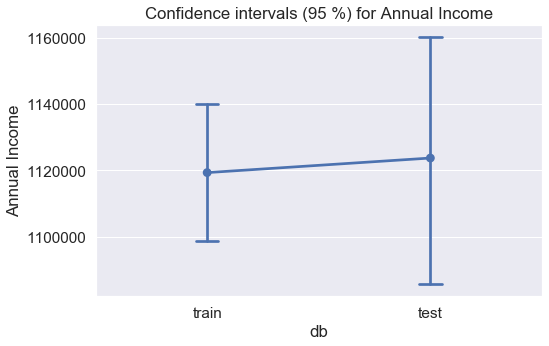

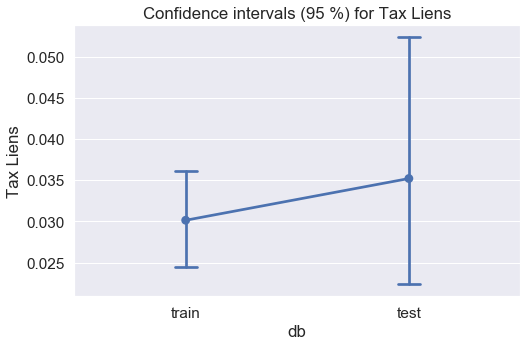

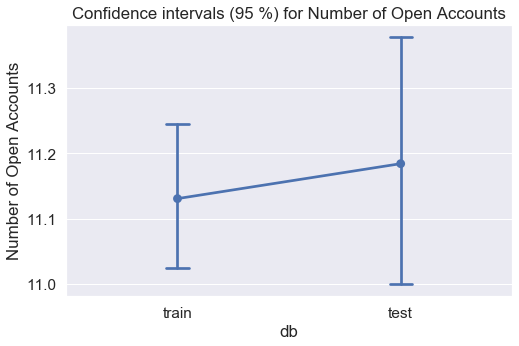

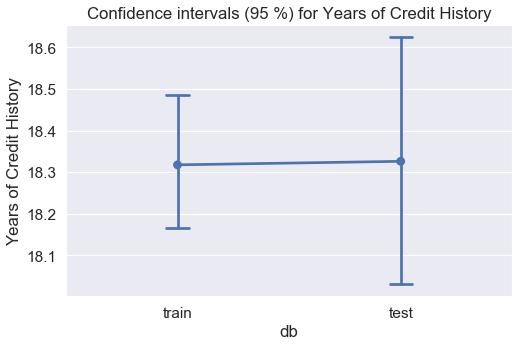

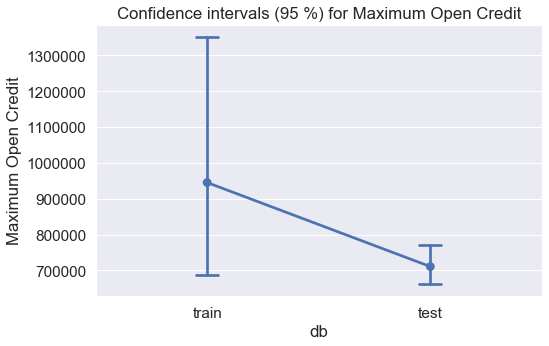

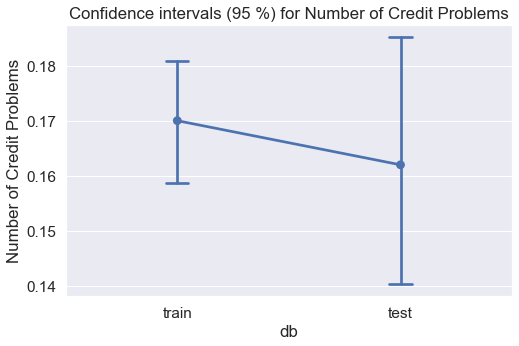

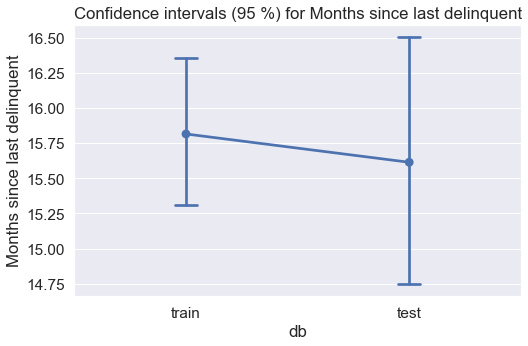

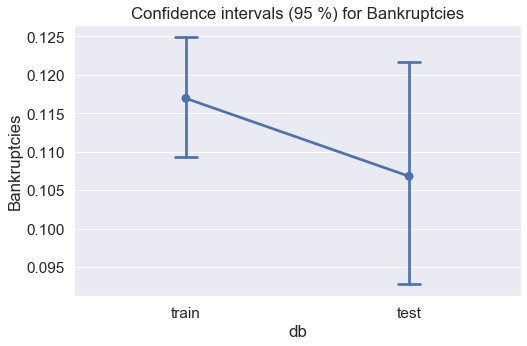

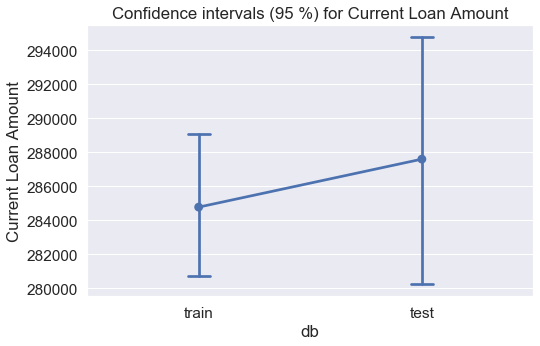

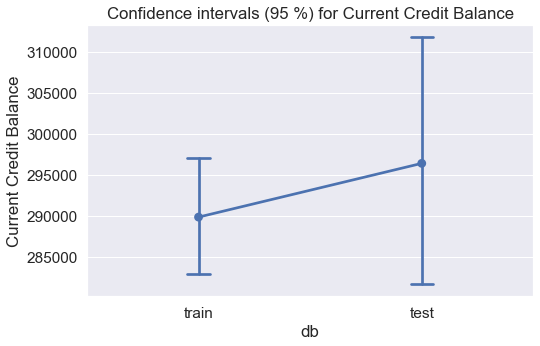

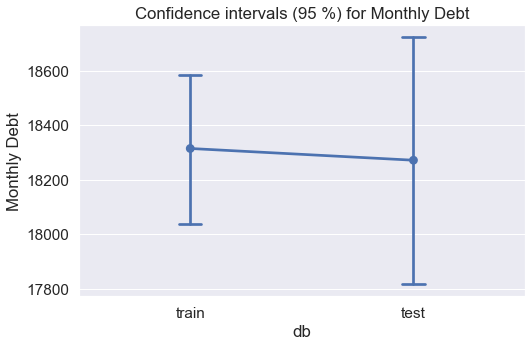

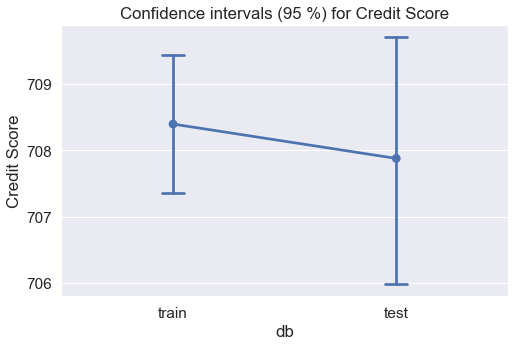

In [42]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x='db', y=vname, data=X, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

С учетом доверительных интервалов можно сказать что распределение параметров на тестовой и тренировочной базе соотвествуют друг другу. Хотя с учетом того что здесь наихудшая оценка в сравнении на тестовой и тренировочной выборке для "Bankruptcies" и учитывая доверительный интервал для целевых парметров - можно рекомендовать "Bankruptcies" не рассматривать для обучения



------

### Масштабирование

In [119]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURES] = scaler.fit_transform(df_norm[NUM_FEATURES])

df = df_norm.copy()
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,-0.708222,< 1 year,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,debt consolidation,Short Term,-1.004283,-0.762772,-0.872085,0.857856,0
1,Own Home,-0.104320,10+ years,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,debt consolidation,Long Term,-0.107667,0.330781,0.004909,0.604334,1
2,Home Mortgage,-0.408910,5 years,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,debt consolidation,Short Term,-1.004283,0.058379,-0.391034,0.709968,0
3,Own Home,-0.349280,5 years,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,debt consolidation,Short Term,-0.887994,-0.610282,-0.584980,-0.304119,0
4,Rent,-0.381291,5 years,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,debt consolidation,Short Term,-0.863840,-0.618292,-0.933631,0.224051,0


In [120]:
df_norm1 = df1.copy()
df_norm1[NUM_FEATURES] = scaler.transform(df_norm1[NUM_FEATURES])

df1 = df_norm1.copy()
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,-1.243985,2 years,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,2.392483,-0.337099,debt consolidation,Short Term,-0.664753,-0.578660,-0.964404,-2.606943
1,Rent,-0.986334,2 years,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.345073,-0.337099,other,Short Term,-1.122236,-0.767016,-1.341313,-0.198485
2,Home Mortgage,0.036879,2 years,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.698307,-0.337099,debt consolidation,Short Term,-0.459806,-0.450977,0.034760,0.371939
3,Home Mortgage,0.112198,10+ years,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,2.392483,-0.337099,debt consolidation,Short Term,-0.366301,-0.241102,0.775161,0.646588
4,Home Mortgage,1.357610,5 years,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.698307,-0.337099,debt consolidation,Long Term,2.678720,0.426483,2.036777,-0.050597


In [121]:
df1.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.004874,0.018656,0.010892,0.001201,-0.014638,-0.016046,-0.008884,-0.029213,0.015339,0.020649,-0.003615,-0.010938
std,1.059137,1.422355,0.988628,1.030275,0.094351,1.123012,0.998605,1.029153,1.004372,1.190190,0.967962,0.997113
min,-1.243985,-0.110953,-2.063916,-2.047506,-0.058979,-0.340979,-0.698307,-0.337099,-1.463972,-0.911855,-1.527880,-2.606943
25%,-0.615240,-0.110953,-0.637847,-0.698357,-0.041595,-0.340979,-0.698307,-0.337099,-0.870925,-0.565420,-0.695097,-0.198485
50%,-0.131971,-0.110953,-0.230398,-0.187101,-0.029109,-0.340979,-0.698307,-0.337099,-0.150414,-0.259393,-0.140194,0.414193
75%,0.410496,-0.110953,0.584498,0.537179,-0.008896,-0.340979,0.493855,-0.337099,0.620228,0.240727,0.488979,0.625461
max,15.399016,55.120285,7.511121,4.982270,3.340951,29.745393,2.922333,14.077056,2.741017,18.059620,6.308967,0.900110


### Reduce

In [122]:
FEATURES_PCA = [
#                 'Annual Income',  
                'Tax Liens',
                'Number of Open Accounts',
                'Years of Credit History',
#                 'Maximum Open Credit',
                'Number of Credit Problems',
                'Months since last delinquent',
                'Bankruptcies',
#                 'Current Loan Amount',
                'Current Credit Balance',
                'Monthly Debt',
#                 'Credit Score'
               ]

In [123]:
pca_trans = PCA(n_components=2)
X_new_PCA= pca_trans.fit_transform(df.loc[:,FEATURES_PCA].values)
X_new_PCA

array([[ 2.55496512e+00,  7.39849633e-01],
       [-7.63724611e-01,  1.36006236e-02],
       [-5.42354305e-01,  3.60714164e-01],
       ...,
       [-7.22983150e-01,  4.70894554e-01],
       [-1.75402221e+00,  1.98903863e+00],
       [-5.86379702e-04, -1.41707316e+00]])

In [124]:
df['pca1']=X_new_PCA[:,0]
df['pca2']=X_new_PCA[:,1]
df.shape

(7500, 19)

In [125]:
X_new_PCA_t= pca_trans.transform(df1.loc[:,FEATURES_PCA].values)
df1['pca1']=X_new_PCA_t[:,0]
df1['pca2']=X_new_PCA_t[:,1]
df1.shape

(2500, 18)

### Dummies

In [126]:
for cat_colname in CAT_FEATURES:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
0,Own Home,-0.708222,< 1 year,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,...,0,0,0,0,1,1,0,0,0,1
1,Own Home,-0.104320,10+ years,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,...,0,1,0,0,0,1,0,0,1,0
2,Home Mortgage,-0.408910,5 years,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,...,0,0,0,1,0,1,0,0,0,1
3,Own Home,-0.349280,5 years,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,...,0,0,0,1,0,1,0,0,0,1
4,Rent,-0.381291,5 years,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,...,1,0,0,1,0,1,0,0,0,1


In [127]:
for cat_colname in CAT_FEATURES:
    df1 = pd.concat([df1, pd.get_dummies(df1[cat_colname], prefix=cat_colname)], axis=1)
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
0,Rent,-1.243985,2 years,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,2.392483,-0.337099,...,1,0,1,0,0,1,0,0,0,1
1,Rent,-0.986334,2 years,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.345073,-0.337099,...,1,0,1,0,0,0,0,1,0,1
2,Home Mortgage,0.036879,2 years,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.698307,-0.337099,...,0,0,1,0,0,1,0,0,0,1
3,Home Mortgage,0.112198,10+ years,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,2.392483,-0.337099,...,0,1,0,0,0,1,0,0,0,1
4,Home Mortgage,1.357610,5 years,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.698307,-0.337099,...,0,0,0,1,0,1,0,0,1,0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
Home Ownership                    7500 non-null object
Annual Income                     7500 non-null float64
Years in current job              7500 non-null object
Tax Liens                         7500 non-null float64
Number of Open Accounts           7500 non-null float64
Years of Credit History           7500 non-null float64
Maximum Open Credit               7500 non-null float64
Number of Credit Problems         7500 non-null float64
Months since last delinquent      7500 non-null float64
Bankruptcies                      7500 non-null float64
Purpose                           7500 non-null object
Term                              7500 non-null object
Current Loan Amount               7500 non-null float64
Current Credit Balance            7500 non-null float64
Monthly Debt                      7500 non-null float64
Credit Score                      7500 non-null float64
C

In [129]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
Home Ownership                    2500 non-null object
Annual Income                     2500 non-null float64
Years in current job              2500 non-null object
Tax Liens                         2500 non-null float64
Number of Open Accounts           2500 non-null float64
Years of Credit History           2500 non-null float64
Maximum Open Credit               2500 non-null float64
Number of Credit Problems         2500 non-null float64
Months since last delinquent      2500 non-null float64
Bankruptcies                      2500 non-null float64
Purpose                           2500 non-null object
Term                              2500 non-null object
Current Loan Amount               2500 non-null float64
Current Credit Balance            2500 non-null float64
Monthly Debt                      2500 non-null float64
Credit Score                      2500 non-null float64
p

In [131]:
NUM_FEATURES_full = df.columns.drop(CAT_FEATURES +[TARGET_NAME]).tolist()
NUM_FEATURES_full

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'pca1',
 'pca2',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_5 years',
 'Years in current job_< 1 year',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_other',
 'Term_Long Term',
 'Term_Short Term']

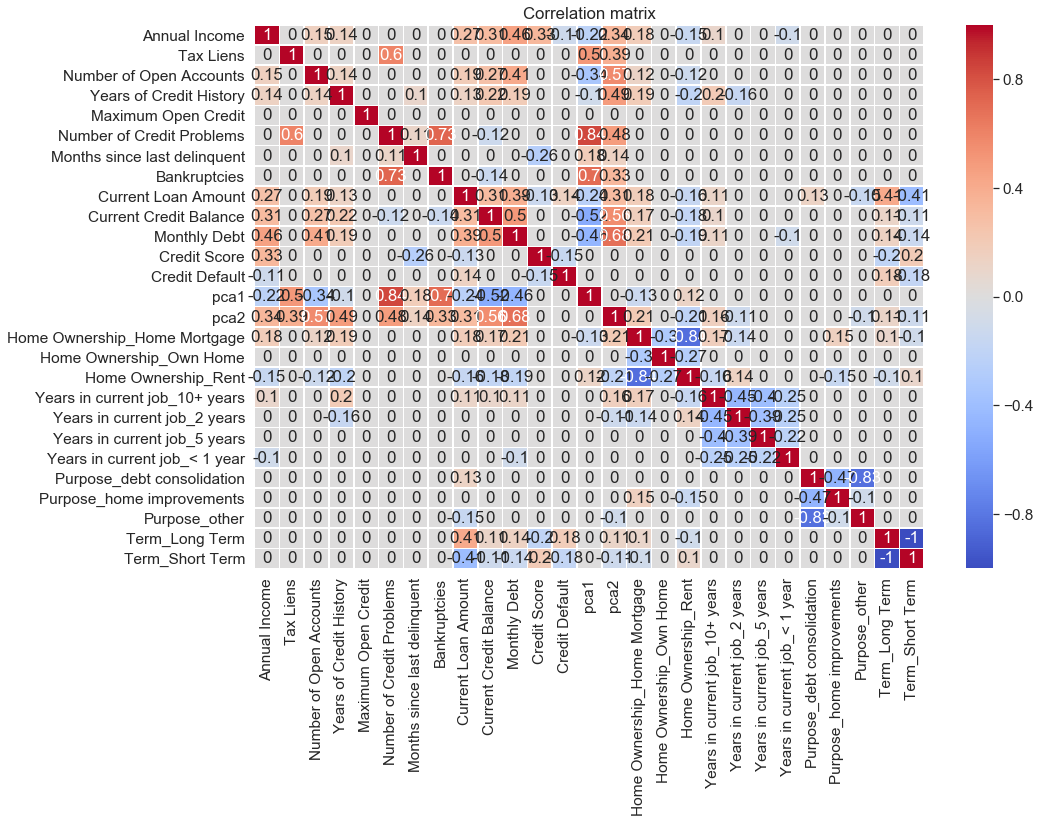

In [132]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

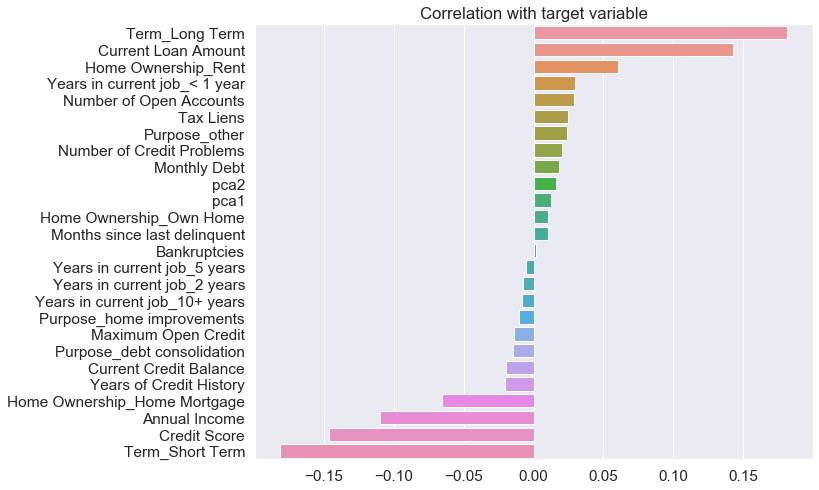

In [133]:
corr_with_target = df[NUM_FEATURES_full + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

----

### Выбор переменных и train_test_split

In [134]:
SELECTED_FEATURE_NAMES = [
    'Annual Income',
#      'Tax Liens',
     'Number of Open Accounts',
     'Years of Credit History',
     'Maximum Open Credit',
#      'Number of Credit Problems',
     'Months since last delinquent',
#      'Bankruptcies',
     'Current Loan Amount',
     'Current Credit Balance',
#      'Monthly Debt',
     'Credit Score',
     'pca1',
     'pca2',
     'Home Ownership_Home Mortgage',
     'Home Ownership_Own Home',
     'Home Ownership_Rent',
     'Years in current job_10+ years',
     'Years in current job_2 years',
     'Years in current job_5 years',
     'Years in current job_< 1 year',
     'Purpose_debt consolidation',
     'Purpose_home improvements',
     'Purpose_other',
     'Term_Long Term',
     'Term_Short Term'
]



In [135]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

In [136]:
X.isnull().sum()

Annual Income                     0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Months since last delinquent      0
Current Loan Amount               0
Current Credit Balance            0
Credit Score                      0
pca1                              0
pca2                              0
Home Ownership_Home Mortgage      0
Home Ownership_Own Home           0
Home Ownership_Rent               0
Years in current job_10+ years    0
Years in current job_2 years      0
Years in current job_5 years      0
Years in current job_< 1 year     0
Purpose_debt consolidation        0
Purpose_home improvements         0
Purpose_other                     0
Term_Long Term                    0
Term_Short Term                   0
dtype: int64

##### Балансировка

In [91]:
# oversample = SMOTE(k_neighbors=3)
# X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)
# print('до баллансировки :',np.sum(y_train))
# print('после баллансировки :',np.sum(y_train_bal))

до баллансировки : 1455
после баллансировки : 3795


In [137]:
oversample = RandomOverSampler()
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

print('y_train', Counter(y_train))
print('y_train_bal', Counter(y_train_bal))

y_train Counter({0: 3795, 1: 1455})
y_train_bal Counter({1: 3795, 0: 3795})


## Изучение моделей

In [67]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print(f'F1-score = {f1_score(y_test_true, y_test_pred)}\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### LogisticRegression

In [68]:
model_lr = LogisticRegression()
model_lr.fit(X_train_bal, y_train_bal)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      3795
           1       0.40      0.60      0.48      1455

    accuracy                           0.64      5250
   macro avg       0.61      0.63      0.60      5250
weighted avg       0.70      0.64      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1592
           1       0.40      0.56      0.47       658

    accuracy                           0.62      2250
   macro avg       0.59      0.61      0.59      2250
weighted avg       0.67      0.62      0.64      2250

F1-score = 0.46725440806045343

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1033  559
1                287  371


#### KNeighborsClassifier

In [69]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_bal, y_train_bal)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3795
           1       0.52      0.82      0.64      1455

    accuracy                           0.74      5250
   macro avg       0.72      0.76      0.72      5250
weighted avg       0.80      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.58      0.64      1592
           1       0.32      0.47      0.38       658

    accuracy                           0.55      2250
   macro avg       0.52      0.53      0.51      2250
weighted avg       0.61      0.55      0.57      2250

F1-score = 0.37979306147291536

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               919  673
1               346  312


#### LGBMClassifier

In [71]:
# model_lgbm = lgbm.LGBMClassifier(n_estimators=80,  
#                                   max_depth=3,                                  
#                                   min_samples_leaf=10,
#                                  random_state=42)
model_lgbm = lgbm.LGBMClassifier(n_estimators=400,  
                                  max_depth=15,                                  
                                  min_samples_leaf=5,
                                 reg_alpha=20,
#                                  reg_lambda=5000,
                                 random_state=42)
# model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train_bal, y_train_bal)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3795
           1       0.53      0.81      0.64      1455

    accuracy                           0.75      5250
   macro avg       0.72      0.77      0.73      5250
weighted avg       0.80      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1592
           1       0.42      0.59      0.49       658

    accuracy                           0.64      2250
   macro avg       0.61      0.62      0.60      2250
weighted avg       0.68      0.64      0.65      2250

F1-score = 0.48768161718256475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1053  539
1                272  386


#### CatBoostClassifier

In [72]:
model_catb = catb.CatBoostClassifier(silent=True, n_estimators=1000,  
                                  max_depth=10, l2_leaf_reg=100, random_state=42)
model_catb.fit(X_train_bal, y_train_bal)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3795
           1       0.82      0.93      0.87      1455

    accuracy                           0.92      5250
   macro avg       0.89      0.92      0.91      5250
weighted avg       0.93      0.92      0.92      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1592
           1       0.42      0.44      0.43       658

    accuracy                           0.66      2250
   macro avg       0.59      0.60      0.59      2250
weighted avg       0.66      0.66      0.66      2250

F1-score = 0.4322723908216136

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1191  401
1                366  292


In [73]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 5.0], silent=True, n_estimators=200,  
#                                    max_depth=7,random_state=42)
# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [75]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.0], silent=True, n_estimators=200,  
#                                   max_depth=10, random_state=42)
model_catb_cw = catb.CatBoostClassifier(class_weights=[1, 3.0], silent=True, n_estimators=700,  
                                  max_depth=10, l2_leaf_reg=10, random_state=42)
model_catb_cw.fit(X_train_bal, y_train_bal)

y_train_pred = model_catb_cw.predict(X_train)
y_test_pred = model_catb_cw.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3795
           1       0.68      1.00      0.81      1455

    accuracy                           0.87      5250
   macro avg       0.84      0.91      0.86      5250
weighted avg       0.91      0.87      0.88      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.56      0.66      1592
           1       0.39      0.67      0.49       658

    accuracy                           0.59      2250
   macro avg       0.59      0.61      0.58      2250
weighted avg       0.68      0.59      0.61      2250

F1-score = 0.48911222780569513

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               897  695
1               220  438


#### RandomForestClassifier

In [150]:
model_rf = RandomForestClassifier(n_estimators=400,  
                                  max_depth=3,                                  
                                  min_samples_leaf=25,
                                  random_state=42)
# model_rf = RandomForestClassifier(n_estimators=150,  
#                                   max_depth=20,                                  
#                                   min_samples_leaf=7,
#                                   random_state=42)

model_rf.fit(X_train_bal, y_train_bal)

y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      3795
           1       0.41      0.69      0.51      1455

    accuracy                           0.63      5250
   macro avg       0.62      0.65      0.61      5250
weighted avg       0.72      0.63      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1592
           1       0.40      0.65      0.50       658

    accuracy                           0.62      2250
   macro avg       0.60      0.62      0.59      2250
weighted avg       0.69      0.62      0.63      2250

F1-score = 0.49591598599766634

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               961  631
1               233  425


### SVM

In [77]:
from sklearn import svm

cSVM = svm.SVC()
cSVM.fit(X_train_bal, y_train_bal)


y_train_pred = cSVM.predict(X_train)
y_test_pred= cSVM.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      3795
           1       0.48      0.68      0.56      1455

    accuracy                           0.71      5250
   macro avg       0.67      0.70      0.67      5250
weighted avg       0.75      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.66      0.72      1592
           1       0.40      0.55      0.46       658

    accuracy                           0.63      2250
   macro avg       0.59      0.61      0.59      2250
weighted avg       0.67      0.63      0.64      2250

F1-score = 0.46361880231809405

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1057  535
1                298  360


### Подбор параметров

In [78]:
params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400], 
          'max_depth':[5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [7,10,30]}

gs = GridSearchCV(model_rf, params, 
                  scoring='f1', # метрика 
                  cv=KFold(n_splits=4,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
#gs.fit(X_train, y_train)  # НА TRAIN!
gs.fit(X_train_bal, y_train_bal)  # НА TRAIN!
gs.best_params_, gs.best_score_

({'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 400},
 0.8044188085412052)

In [79]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.357293,0.021731,0.019448,0.001115,5,7,50,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.665970,0.665962,0.678314,0.632871,0.660779,0.016883,126
1,0.647026,0.027921,0.033289,0.004448,5,7,100,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.664567,0.668750,0.683123,0.657143,0.668396,0.009465,115


In [80]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7,10]}
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                       )
rs.fit(X_train_bal, y_train_bal)
rs.best_params_, rs.best_score_

Wall time: 2min 10s


({'n_estimators': 700, 'max_depth': 10}, 0.7796451403681243)

In [81]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7,10]}
rs = RandomizedSearchCV(model_catb_cw, params, scoring='f1', cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                       )
rs.fit(X_train_bal, y_train_bal)
rs.best_params_, rs.best_score_

Wall time: 4min 44s


({'n_estimators': 1000, 'max_depth': 10}, 0.7979391722761768)

In [82]:
params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400], 
          'max_depth':[5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [5,10,20,30]}

gs = GridSearchCV(model_lgbm, params, 
                  scoring='f1', # метрика 
                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
#gs.fit(X_train, y_train)  # НА TRAIN!
gs.fit(X_train_bal, y_train_bal)  # НА TRAIN!
gs.best_params_, gs.best_score_

({'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100},
 0.7036945817945538)

In [89]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_lgbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Number of Open Accounts,386
5,Current Loan Amount,335
0,Annual Income,289
7,Credit Score,289
2,Years of Credit History,251
3,Maximum Open Credit,247
9,pca2,238
6,Current Credit Balance,237
8,pca1,228
4,Months since last delinquent,166


In [90]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_rf.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
5,Current Loan Amount,0.171829
7,Credit Score,0.117276
0,Annual Income,0.104487
3,Maximum Open Credit,0.074458
8,pca1,0.069425
1,Number of Open Accounts,0.067245
6,Current Credit Balance,0.066483
9,pca2,0.065378
2,Years of Credit History,0.062432
21,Term_Short Term,0.054159


In [91]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Number of Open Accounts,16.067576
5,Current Loan Amount,11.965618
0,Annual Income,8.699087
7,Credit Score,7.519677
2,Years of Credit History,6.604525
3,Maximum Open Credit,5.642531
6,Current Credit Balance,5.530372
9,pca2,5.061270
4,Months since last delinquent,4.942827
8,pca1,4.571607


In [185]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb_cw.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Annual Income,16.476877
5,Maximum Open Credit,10.365775
0,Home Ownership,8.536265
7,Purpose,7.166423
2,Years in current job,6.309082
3,Number of Open Accounts,5.387055
4,Years of Credit History,5.207659
9,Current Loan Amount,5.151801
8,Term,5.042357
6,Months since last delinquent,5.014368


### Сравнение моделей

In [138]:
SELECTED_FEATURE_NAMES = [
     'Annual Income',
#      'Tax Liens',
     'Number of Open Accounts',
     'Years of Credit History',
     'Maximum Open Credit',
#      'Number of Credit Problems',
     'Months since last delinquent',
#      'Bankruptcies',
     'Current Loan Amount',
     'Current Credit Balance',
#      'Monthly Debt',
     'Credit Score',
     'pca1',
     'pca2',
     'Home Ownership_Home Mortgage',
     'Home Ownership_Own Home',
     'Home Ownership_Rent',
     'Years in current job_10+ years',
     'Years in current job_2 years',
     'Years in current job_5 years',
     'Years in current job_< 1 year',
     'Purpose_debt consolidation',
     'Purpose_home improvements',
     'Purpose_other',
     'Term_Long Term',
     'Term_Short Term'
]
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]
# X = dfL[SELECTED_FEATURE_NAMES]
# y = dfL[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

# Балансировка
oversample = SMOTE(k_neighbors=3)
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

# print('до баллансировки :',np.sum(y_train))
# print('после баллансировки :',np.sum(y_train_bal))

In [139]:
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()
model_lgbm = lgbm.LGBMClassifier(n_estimators=100,  
                                  max_depth= 15,                                  
                                  min_samples_leaf= 5,
                                 random_state=42)
model_catb = catb.CatBoostClassifier(silent=True, n_estimators=700,  
                                  max_depth=10, random_state=42)
model_catb_cw = catb.CatBoostClassifier(class_weights=[1, 4.0], silent=True, n_estimators=1000,  
                                  max_depth=10,  random_state=42)
model_rf = RandomForestClassifier(n_estimators=400,  
                                  max_depth=20,                                  
                                  min_samples_leaf=7,
                                  random_state=42)
cSVM = svm.SVC()

MODELS = {
    'LogisticRegression': model_lr,
    'KNeighborsClassifier': model_knn,
    'LGBMClassifier': model_lgbm,
    'CatBoostClassifier' : model_catb,
    'CatBoostClassifier_CW' : model_catb_cw,
    'RandomForestClassifier' : model_rf,
    'SVM' : cSVM
}

In [140]:
print('Model'.ljust(30),'F1-score test'.ljust(26),'F1-score train')
print('-'*80)
for i in MODELS:
    model = MODELS[i]
    model.fit(X_train_bal, y_train_bal)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
#     print(i.ljust(30), f'F1-score = {f1_score(y_test, y_test_pred)}')
    print(i.ljust(30), f'{f1_score(y_test, y_test_pred)}\t', f1_score(y_train, y_train_pred))

Model                          F1-score test              F1-score train
--------------------------------------------------------------------------------
LogisticRegression             0.4266666666666667	 0.4328205128205128
KNeighborsClassifier           0.40197897340754485	 0.6735889243876465
LGBMClassifier                 0.41646090534979424	 0.7943362831858407
CatBoostClassifier             0.38811188811188807	 0.9979353062629043
CatBoostClassifier_CW          0.4852498494882601	 0.9171131421367791
RandomForestClassifier         0.4566010211524435	 0.8206646923330043
SVM                            0.4289985052316891	 0.5418169891767793


In [87]:
print('Model'.ljust(30),'F1-score test'.ljust(26),'F1-score train')
print('-'*80)
for i in MODELS:
    model = MODELS[i]
    model.fit(X_train_bal, y_train_bal)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
#     print(i.ljust(30), f'F1-score = {f1_score(y_test, y_test_pred)}')
    print(i.ljust(30), f'{f1_score(y_test, y_test_pred)}\t', f1_score(y_train, y_train_pred))

Model                          F1-score test              F1-score train
--------------------------------------------------------------------------------
LogisticRegression             0.4301242236024844	 0.4412859560067682
KNeighborsClassifier           0.40320591861898897	 0.6841825902335457
LGBMClassifier                 0.4090909090909091	 0.7962184873949579
CatBoostClassifier             0.37209302325581395	 0.9989680082559339
CatBoostClassifier_CW          0.4819277108433735	 0.917981072555205
RandomForestClassifier         0.45119305856832975	 0.8185985592665357
SVM                            0.42322383498854094	 0.5406841580870143


In [74]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [88]:
model = VotingClassifier(estimators=[('lr', model_lr), ('svm', cSVM), ('knn', model_knn), 
                                     ('cb', model_catb), ('cb_cw', model_catb_cw), ('rf', model_rf), ('lgbm', model_lgbm)],
                         voting='hard', weights=[1, 1, 1, 1, 2, 2, 1])
model = model.fit(X_train_bal, y_train_bal)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3795
           1       0.82      0.90      0.86      1455

    accuracy                           0.92      5250
   macro avg       0.89      0.91      0.90      5250
weighted avg       0.92      0.92      0.92      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1592
           1       0.42      0.45      0.43       658

    accuracy                           0.66      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.66      0.66      0.66      2250

F1-score = 0.43056576047024253

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1182  410
1                365  293


-----

Самыми перспективными выглядят следующие модели:

1. CatBoostClassifier_CW (с весом на целевой класс)
2. RandomForestClassifier
3. LGBMClassifier 


Кроме того стоит отметить что для CatBoostClassifier можно брать данные прямо с категорийными параметрами. 

### CatBoostClassifier с обработкой категорийных параметров

In [300]:
SEL_FEATURES = ['Home Ownership',
 'Annual Income',
 'Years in current job',
#  'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
#  'Number of Credit Problems',
 'Months since last delinquent',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'pca1',
 'pca2'
               ]

In [360]:
Xc = df[SEL_FEATURES]
yc = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, shuffle=True, test_size=0.30, random_state=42)

In [79]:
# X = dfL[SEL_FEATURES]
# y = dfL[TARGET_NAME]

# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

In [302]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [361]:
%%time
model_catb_c = catb.CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=42)
model_catb_c.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb_c.predict(X_train)
y_test_pred = model_catb_c.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      3795
           1       0.64      0.90      0.75      1455

    accuracy                           0.83      5250
   macro avg       0.80      0.85      0.81      5250
weighted avg       0.87      0.83      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1592
           1       0.43      0.57      0.49       658

    accuracy                           0.65      2250
   macro avg       0.61      0.63      0.61      2250
weighted avg       0.69      0.65      0.67      2250

F1-score = 0.4904918032786885

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1099  493
1                284  374
Wall time: 22 s


In [362]:
%%time
model_catb_c = catb.CatBoostClassifier(class_weights=[1, 4.0], silent=True, random_state=42)
model_catb_c.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb_c.predict(X_train)
y_test_pred = model_catb_c.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.64      0.77      3795
           1       0.51      0.98      0.67      1455

    accuracy                           0.73      5250
   macro avg       0.75      0.81      0.72      5250
weighted avg       0.85      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.53      0.65      1592
           1       0.40      0.76      0.53       658

    accuracy                           0.60      2250
   macro avg       0.62      0.65      0.59      2250
weighted avg       0.71      0.60      0.61      2250

F1-score = 0.5253793825222396

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               841  751
1               156  502
Wall time: 21.7 s


In [358]:
%%time
model_catb_c = catb.CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=21)
model_catb_c.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb_c.predict(X_train)
y_test_pred = model_catb_c.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      3771
           1       0.65      0.91      0.76      1479

    accuracy                           0.84      5250
   macro avg       0.80      0.86      0.82      5250
weighted avg       0.87      0.84      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      1616
           1       0.42      0.60      0.49       634

    accuracy                           0.65      2250
   macro avg       0.61      0.63      0.61      2250
weighted avg       0.70      0.65      0.66      2250

F1-score = 0.4902975420439845

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  533
1                255  379
Wall time: 21.6 s


In [151]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7,10]}
rs = RandomizedSearchCV(model_catb_c, params, scoring='f1', cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                       )
rs.fit(X_train_bal, y_train_bal)
rs.best_params_, rs.best_score_

Wall time: 8min 45s


({'n_estimators': 1500, 'max_depth': 10}, 0.7895984590797768)

In [381]:
model_catb_c = catb.CatBoostClassifier(class_weights=[1, 3.0], silent=True, n_estimators=1500,  
                                  max_depth=3, random_state=42)
model_catb_c.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb_c.predict(X_train)
y_test_pred = model_catb_c.predict(X_test)
y_train_pred_proba = model_catb_c.predict_proba(X_train)
y_test_pred_proba = model_catb_c.predict_proba(X_test)
threshold_prob = 0.52
predict_train = np.array([1 if x>=threshold_prob else 0 for x in y_train_pred_proba[:,1]])
predict_test = np.array([1 if x>=threshold_prob else 0 for x in y_test_pred_proba[:,1]])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
get_classification_report(y_train, predict_train, y_test, predict_test)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.59      0.72      3795
           1       0.44      0.85      0.58      1455

    accuracy                           0.66      5250
   macro avg       0.68      0.72      0.65      5250
weighted avg       0.78      0.66      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.54      0.66      1592
           1       0.40      0.74      0.52       658

    accuracy                           0.60      2250
   macro avg       0.62      0.64      0.59      2250
weighted avg       0.71      0.60      0.62      2250

F1-score = 0.5184788430637387

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               867  725
1               174  484
TRAIN

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      3795
           1       0.46      0.81      0.59      1455

    accuracy 

In [309]:
model_catb_c = catb.CatBoostClassifier(auto_class_weights='Balanced', silent=True, n_estimators=1500,  
                                  max_depth=3, random_state=42)
model_catb_c.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb_c.predict(X_train)
y_test_pred = model_catb_c.predict(X_test)
y_train_pred_proba = model_catb_c.predict_proba(X_train)
y_test_pred_proba = model_catb_c.predict_proba(X_test)
threshold_prob = 0.55
predict_train = np.array([1 if x>=threshold_prob else 0 for x in y_train_pred_proba[:,1]])
predict_test = np.array([1 if x>=threshold_prob else 0 for x in y_test_pred_proba[:,1]])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
get_classification_report(y_train, predict_train, y_test, predict_test)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.67      0.77      3795
           1       0.48      0.78      0.59      1455

    accuracy                           0.70      5250
   macro avg       0.68      0.73      0.68      5250
weighted avg       0.78      0.70      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1592
           1       0.42      0.66      0.51       658

    accuracy                           0.63      2250
   macro avg       0.61      0.64      0.61      2250
weighted avg       0.70      0.63      0.65      2250

F1-score = 0.5094339622641508

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               986  606
1               226  432
TRAIN

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      3795
           1       0.53      0.65      0.58      1455

    accuracy 

In [311]:
threshold_prob = 0.42

predict_train = np.array([1 if x>=threshold_prob else 0 for x in y_train_pred_proba[:,1]])
predict_test = np.array([1 if x>=threshold_prob else 0 for x in y_test_pred_proba[:,1]])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
get_classification_report(y_train, predict_train, y_test, predict_test)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.67      0.77      3795
           1       0.48      0.78      0.59      1455

    accuracy                           0.70      5250
   macro avg       0.68      0.73      0.68      5250
weighted avg       0.78      0.70      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1592
           1       0.42      0.66      0.51       658

    accuracy                           0.63      2250
   macro avg       0.61      0.64      0.61      2250
weighted avg       0.70      0.63      0.65      2250

F1-score = 0.5094339622641508

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               986  606
1               226  432
TRAIN

              precision    recall  f1-score   support

           0       0.94      0.49      0.64      3795
           1       0.41      0.91      0.56      1455

    accuracy 

In [310]:
y_train_pred_proba = model_catb_c.predict_proba(X_train)
y_test_pred_proba = model_catb_c.predict_proba(X_test)
for threshold_prob in np.linspace(0.4,0.6,21):
    predict_train = np.array([1 if x>=threshold_prob else 0 for x in y_train_pred_proba[:,1]])
    predict_test = np.array([1 if x>=threshold_prob else 0 for x in y_test_pred_proba[:,1]])
    print(f'{threshold_prob}  -  {f1_score(y_test, predict_test)} - {f1_score(y_train, predict_train)}')

    

0.4  -  0.5256229431123648 - 0.5568274734260017
0.41000000000000003  -  0.5251557259223766 - 0.558071888634947
0.42000000000000004  -  0.5269286754002912 - 0.5612180164939734
0.43  -  0.5200197726149284 - 0.5639585133967157
0.44  -  0.5185185185185185 - 0.5683469073299582
0.45  -  0.5165631469979296 - 0.5746031746031746
0.46  -  0.5140434552199258 - 0.5829075708313981
0.47000000000000003  -  0.5141612200435729 - 0.5859114707282247
0.48  -  0.514253773057574 - 0.5873132500612295
0.49  -  0.506880733944954 - 0.5900479919171507
0.5  -  0.5094339622641508 - 0.5927083333333334
0.51  -  0.5021380574221136 - 0.5967828418230562
0.52  -  0.4977834072197594 - 0.5918141592920354
0.53  -  0.4931862426995457 - 0.5910908052541405
0.54  -  0.4905913978494624 - 0.5869822485207101
0.55  -  0.4787752261656228 - 0.5815950920245399
0.56  -  0.4654178674351585 - 0.5759694850603942
0.5700000000000001  -  0.4530551415797317 - 0.5672227674190382
0.58  -  0.448727833461835 - 0.5639986491050321
0.59  -  0.43256

In [186]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb_c.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
9,Current Loan Amount,30.838849
1,Annual Income,10.052787
12,Credit Score,7.524779
5,Maximum Open Credit,7.151717
10,Current Credit Balance,6.180881
11,Monthly Debt,6.136709
4,Years of Credit History,6.047536
14,pca2,5.493865
13,pca1,4.451207
3,Number of Open Accounts,3.581890


In [103]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,-1.831424e-16,-4.879911e-16,8.967641e-17,-1.913728e-16,-7.831652e-17,1.222888e-15,-3.812358e-16,-1.917873e-16,-1.186014e-16,3.139132e-17,...,0.427200,0.310933,0.306400,0.258133,0.124533,0.792533,0.054933,0.152533,0.259200,0.740800
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,...,0.494705,0.462906,0.461029,0.437637,0.330211,0.405520,0.227865,0.359561,0.438225,0.438225
min,-1.243985e+00,-1.109534e-01,-1.860192e+00,-2.033305e+00,-5.897941e-02,-3.409789e-01,-6.983066e-01,-3.370990e-01,-1.486691e+00,-9.118548e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.110699e-01,-1.109534e-01,-6.378469e-01,-6.841558e-01,-4.155495e-02,-3.409789e-01,-6.983066e-01,-3.370990e-01,-8.430647e-01,-5.523883e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.426338e-01,-1.109534e-01,-2.303985e-01,-1.871009e-01,-2.914137e-02,-3.409789e-01,-6.983066e-01,-3.370990e-01,-2.556372e-01,-2.532962e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,4.232079e-01,-1.109534e-01,5.844983e-01,4.945743e-01,-9.463390e-03,-3.409789e-01,5.821636e-01,-3.370990e-01,6.095562e-01,2.220323e-01,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.003539e+01,2.566362e+01,6.492500e+00,5.592937e+00,8.135844e+01,1.369933e+01,4.511882e+00,1.119423e+01,2.740659e+00,1.955941e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
df1.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.004874,0.018656,0.010892,0.001201,-0.014638,-0.016046,-0.008884,-0.029213,0.015339,0.020649,...,0.408000,0.324000,0.298000,0.260800,0.117200,0.789200,0.056000,0.154800,0.255600,0.744400
std,1.059137,1.422355,0.988628,1.030275,0.094351,1.123012,0.998605,1.029153,1.004372,1.190190,...,0.491561,0.468094,0.457471,0.439159,0.321723,0.407958,0.229968,0.361786,0.436285,0.436285
min,-1.243985,-0.110953,-2.063916,-2.047506,-0.058979,-0.340979,-0.698307,-0.337099,-1.463972,-0.911855,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.615240,-0.110953,-0.637847,-0.698357,-0.041595,-0.340979,-0.698307,-0.337099,-0.870925,-0.565420,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.131971,-0.110953,-0.230398,-0.187101,-0.029109,-0.340979,-0.698307,-0.337099,-0.150414,-0.259393,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.410496,-0.110953,0.584498,0.537179,-0.008896,-0.340979,0.493855,-0.337099,0.620228,0.240727,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,15.399016,55.120285,7.511121,4.982270,3.340951,29.745393,2.922333,14.077056,2.741017,18.059620,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Обучение финальной модели

In [312]:
Xc = df[SEL_FEATURES]
yc = df[TARGET_NAME]
Xtest = df1[SEL_FEATURES]

In [407]:
model_catb_c = catb.CatBoostClassifier(auto_class_weights='Balanced', silent=True, n_estimators=1500,  
                                  max_depth=3, random_state=42)
model_catb_c.fit(Xc, yc, CAT_FEATURES)
y_train_pred = model_catb_c.predict(Xc)
y_train_pred_proba = model_catb_c.predict_proba(Xc)
threshold_prob = 0.42
predict_train = np.array([1 if x>=threshold_prob else 0 for x in y_train_pred_proba[:,1]])

get_classification_report(yc, y_train_pred, yc, predict_train)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      5387
           1       0.46      0.79      0.58      2113

    accuracy                           0.68      7500
   macro avg       0.67      0.72      0.66      7500
weighted avg       0.77      0.68      0.70      7500

TEST

              precision    recall  f1-score   support

           0       0.93      0.46      0.62      5387
           1       0.40      0.92      0.56      2113

    accuracy                           0.59      7500
   macro avg       0.67      0.69      0.59      7500
weighted avg       0.78      0.59      0.60      7500

F1-score = 0.5568165493463583

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               2477  2910
1                175  1938


In [420]:
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final.to_csv('KarashchukAF_predictions.csv')
y_final.head()

,Credit Default
0,1
1,1
2,0
3,0
4,0


In [418]:
y_final[TARGET_NAME].value_counts()

0    1292
1    1208
Name: Credit Default, dtype: int64

In [414]:
y_pred = model_catb_c.predict(Xtest)
y_pred_proba = model_catb_c.predict_proba(Xtest)


In [415]:
threshold_prob = 0.55
predict = np.array([1 if x>=threshold_prob else 0 for x in y_pred_proba[:,1]])


In [416]:
y_f=pd.DataFrame(predict, columns=[TARGET_NAME])
y_f[TARGET_NAME].value_counts()

0    1588
1     912
Name: Credit Default, dtype: int64

In [417]:
y_f.head()

,Credit Default
0,1
1,1
2,0
3,0
4,0
